# Time Series - TensorFlow
Provincial with series manipulation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'

In [6]:
df = covidpro_df[covidpro_df.Province == province].query('20200801 > Date')

In [7]:
df = df.set_index(date)

In [8]:
df = df.loc[:, ['New_cases', 'Deaths']]

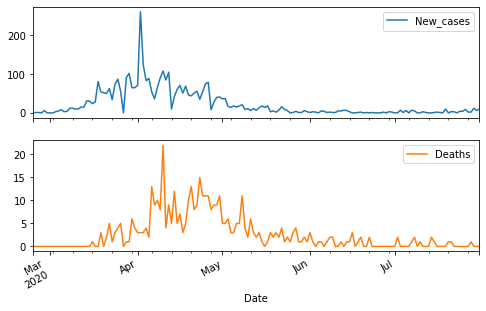

In [9]:
df.plot(subplots=True, figsize=(8,5))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
New_cases,159.0,22.817610,34.652498,0.0,1.0,7.0,35.5,261.0
Deaths,159.0,2.622642,3.742806,0.0,0.0,1.0,3.5,22.0


**NB** Now we make both `New_cases` and `Deaths` series stationary, we remove the trend and seasonality

In [11]:
res = np.log(df[compart]) - np.log(df[compart]).shift(1)
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')

res_fix.dropna(inplace=True)

decomposed = seasonal_decompose(res_fix,model='additive',extrapolate_trend='freq')
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

In [12]:
adf_test(deseasonalized.values)
kpss_test(deseasonalized.values)

ADF Statistic: -10.083327962059796
p-value: 1.1728864852470525e-17
Critial Values:
   1%, -3.4729792729247793
Critial Values:
   5%, -2.8802520918255534
Critial Values:
   10%, -2.5767469641683105

KPSS Statistic: 0.093547
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


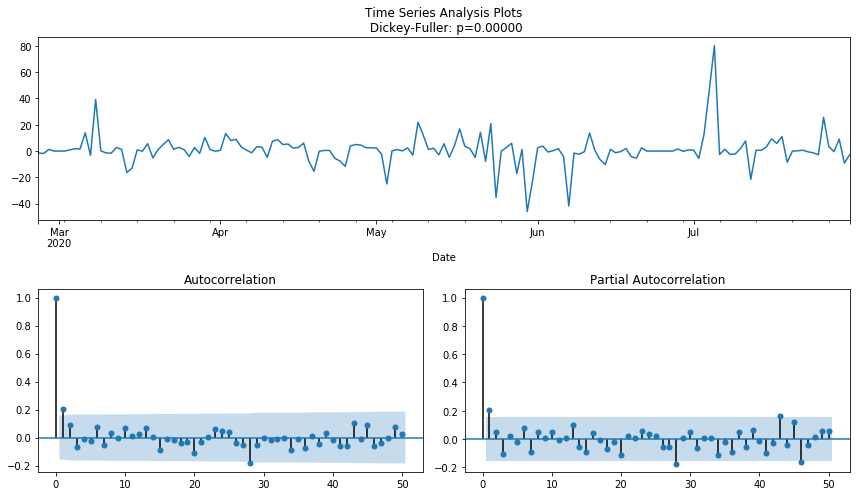

In [13]:
tsplot(deseasonalized, lags=50)

In [14]:
df_temp = pd.DataFrame(deseasonalized, columns=[compart])

In [15]:
res = np.log(df['Deaths']) - np.log(df['Deaths']).shift(1)
res_fix = res.replace([np.inf, -np.inf], np.nan).interpolate(method='time')

res_fix.dropna(inplace=True)

decomposed = seasonal_decompose(res_fix,model='additive',extrapolate_trend='freq')
detrended = res_fix - decomposed.trend
deseasonalized = detrended / decomposed.seasonal

adf_test(deseasonalized.values)
kpss_test(deseasonalized.values)

ADF Statistic: -5.4905331570359905
p-value: 2.180401202216383e-06
Critial Values:
   1%, -3.4870216863700767
Critial Values:
   5%, -2.8863625166643136
Critial Values:
   10%, -2.580009026141913

KPSS Statistic: 0.061227
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
/home/nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


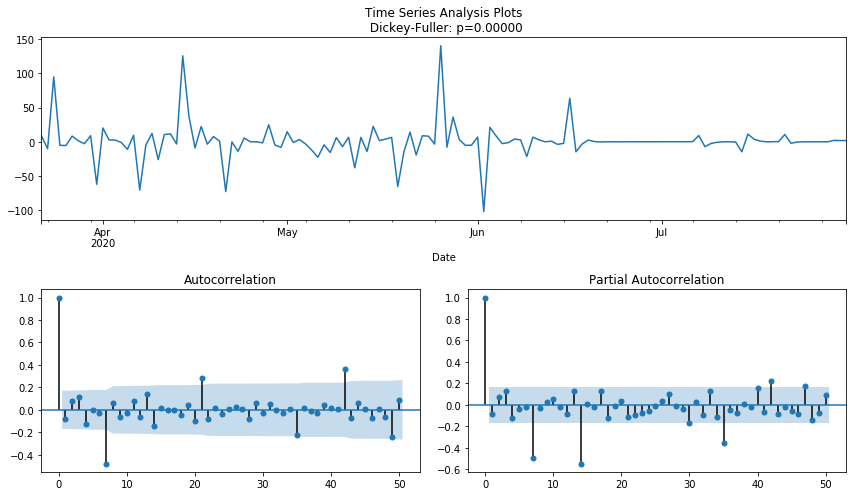

In [16]:
tsplot(deseasonalized, lags=50)

In [17]:
df_temp['Deaths'] = deseasonalized
df = df_temp.copy()

In [18]:
df.fillna(0, inplace=True)

In [19]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [21]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['New_cases']

In [22]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [23]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 3.1525 - mean_absolute_error: 0.8639 - mean_squared_error: 3.1525


In [24]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [25]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['New_cases']

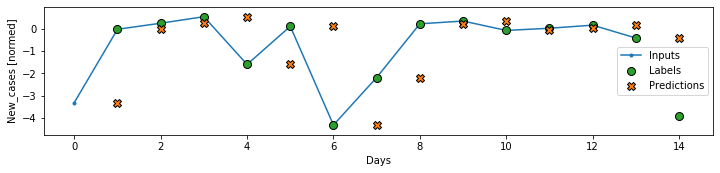

In [26]:
wide_window.plot(baseline)

In [27]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [28]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 38ms/step - loss: 4.3932 - mean_absolute_error: 1.4294 - mean_squared_error: 4.3932 - val_loss: 5.0784 - val_mean_absolute_error: 1.1261 - val_mean_squared_error: 5.0784
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 4.3710 - mean_absolute_error: 1.4261 - mean_squared_error: 4.3710 - val_loss: 5.0591 - val_mean_absolute_error: 1.1245 - val_mean_squared_error: 5.0591
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 4.3545 - mean_absolute_error: 1.4234 - mean_squared_error: 4.3545 - val_loss: 5.0395 - val_mean_absolute_error: 1.1231 - val_mean_squared_error: 5.0395
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 4.3371 - mean_absolute_error: 1.4205 - mean_squared_error: 4.3371 - val_loss: 5.0203 - val_mean_absolute_error: 1.1218 - val_mean_squared_error: 5.0203
Epoch 5/50
4/4 [==============================] - 0s 18ms/step - loss: 4.3182 - mean_absolute_error: 1.4177 

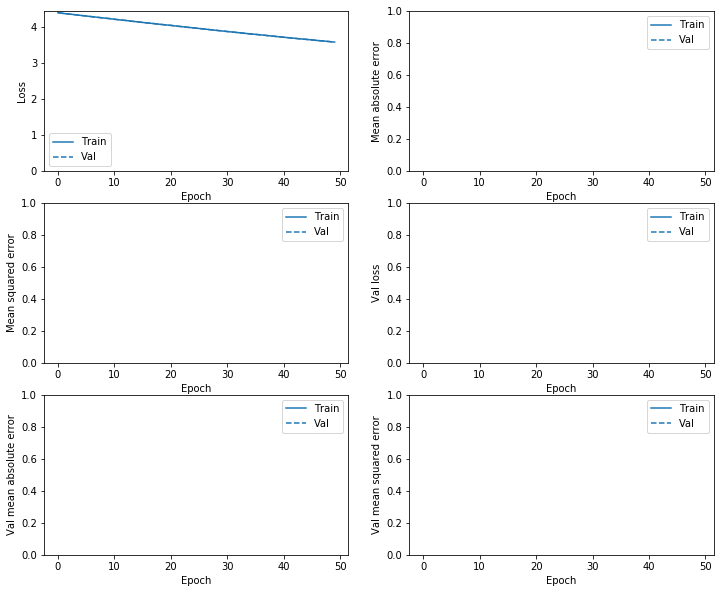

In [29]:
plot_metrics(history)

In [30]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 4.2139 - mean_absolute_error: 1.0649 - mean_squared_error: 4.2139


In [31]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

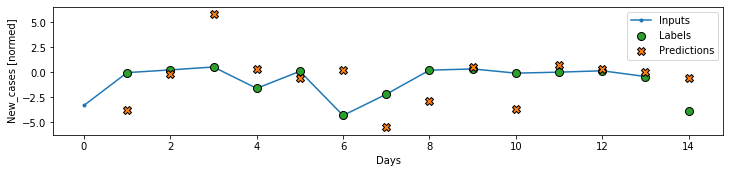

In [32]:
wide_window.plot(linear)

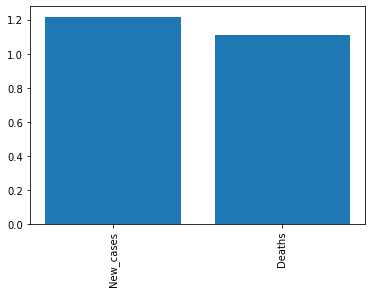

In [33]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 61ms/step - loss: 1.0115 - mean_absolute_error: 0.6365 - mean_squared_error: 1.0115 - val_loss: 2.8078 - val_mean_absolute_error: 0.6595 - val_mean_squared_error: 2.8078
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.9836 - mean_absolute_error: 0.6036 - mean_squared_error: 0.9836 - val_loss: 2.6670 - val_mean_absolute_error: 0.6464 - val_mean_squared_error: 2.6670
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.9788 - mean_absolute_error: 0.5850 - mean_squared_error: 0.9788 - val_loss: 2.5957 - val_mean_absolute_error: 0.6545 - val_mean_squared_error: 2.5957
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - loss: 0.9745 - mean_absolute_error: 0.5826 - mean_squared_error: 0.9745 - val_loss: 2.5934 - val_mean_absolute_error: 0.6581 - val_mean_squared_error: 2.5934
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.9700 - mean_absolute_error: 0.5849 

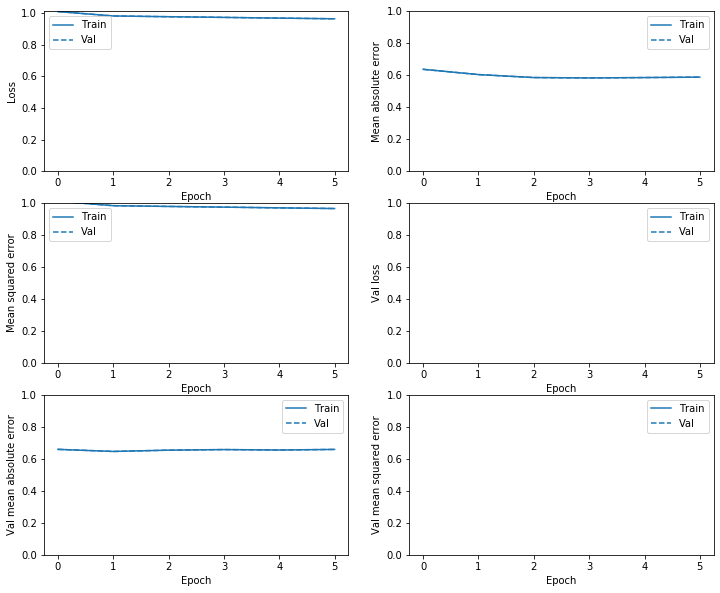

In [35]:
plot_metrics(history)

In [36]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 2.7239 - mean_absolute_error: 0.6591 - mean_squared_error: 2.7239


In [37]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [38]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['New_cases']

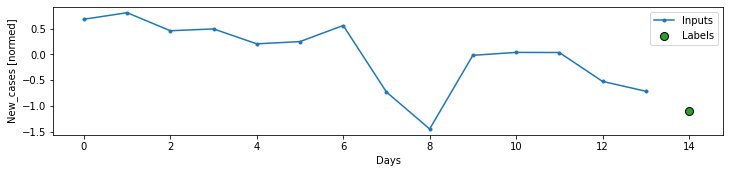

In [39]:
conv_window.plot()

In [40]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [41]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/50
3/3 [==============================] - 0s 57ms/step - loss: 1.1594 - mean_absolute_error: 0.8166 - mean_squared_error: 1.1594 - val_loss: 5.4010 - val_mean_absolute_error: 1.2959 - val_mean_squared_error: 5.4010
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0337 - mean_absolute_error: 0.7330 - mean_squared_error: 1.0337 - val_loss: 5.3455 - val_mean_absolute_error: 1.2838 - val_mean_squared_error: 5.3455
Epoch 3/50
3/3 [==============================] - 0s 31ms/step - loss: 0.9684 - mean_absolute_error: 0.6800 - mean_squared_error: 0.9684 - val_loss: 5.3185 - val_mean_absolute_error: 1.2732 - val_mean_squared_error: 5.3185
Epoch 4/50
3/3 [==============================] - 0s 28ms/step - loss: 0.9167 - mean_absolute_error: 0.6482 - mean_squared_error: 0.9167 - val_loss: 5.2849 - val_mean_absolute_error: 1.2631 - val_mean_squared_error: 5.2849
Epoch 5/50
3/3 [==============================] - 0s 24ms/step - loss: 0.8720 - mean_absolute_error: 0.6264 

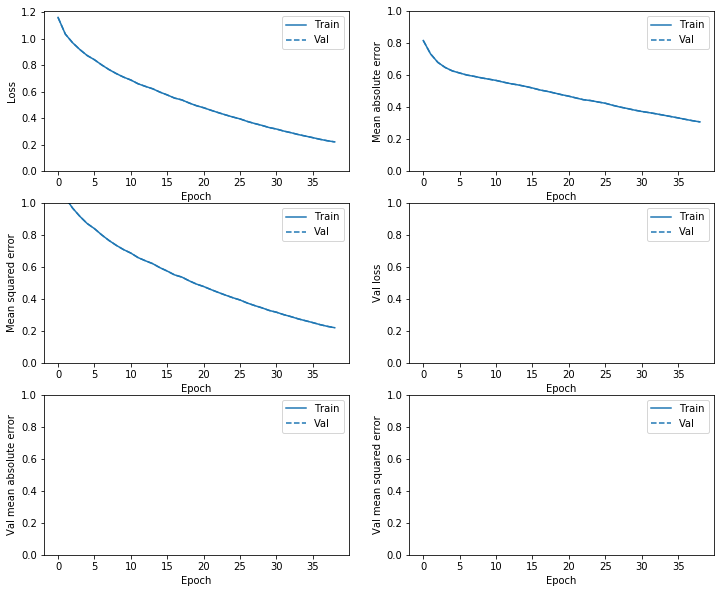

In [42]:
plot_metrics(history)

In [43]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 4.8727 - mean_absolute_error: 1.1853 - mean_squared_error: 4.8727


In [44]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

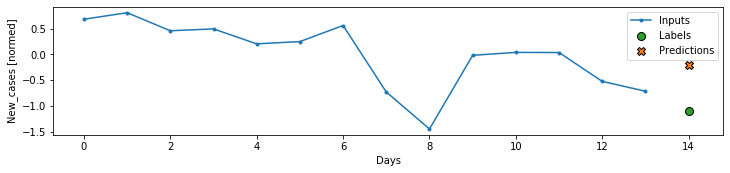

In [45]:
conv_window.plot(multi_step_dense)

In [46]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [47]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
3/3 [==============================] - 0s 153ms/step - loss: 0.9899 - mean_absolute_error: 0.5977 - mean_squared_error: 0.9899 - val_loss: 3.5521 - val_mean_absolute_error: 0.7446 - val_mean_squared_error: 3.5521
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 0.9779 - mean_absolute_error: 0.5961 - mean_squared_error: 0.9779 - val_loss: 3.5332 - val_mean_absolute_error: 0.7445 - val_mean_squared_error: 3.5332
Epoch 3/50
3/3 [==============================] - 0s 25ms/step - loss: 0.9684 - mean_absolute_error: 0.5951 - mean_squared_error: 0.9684 - val_loss: 3.5182 - val_mean_absolute_error: 0.7448 - val_mean_squared_error: 3.5182
Epoch 4/50
3/3 [==============================] - 0s 28ms/step - loss: 0.9594 - mean_absolute_error: 0.5945 - mean_squared_error: 0.9594 - val_loss: 3.5048 - val_mean_absolute_error: 0.7452 - val_mean_squared_error: 3.5048
Epoch 5/50
3/3 [==============================] - 0s 30ms/step - loss: 0.9512 - mean_absolute_error: 0.5944

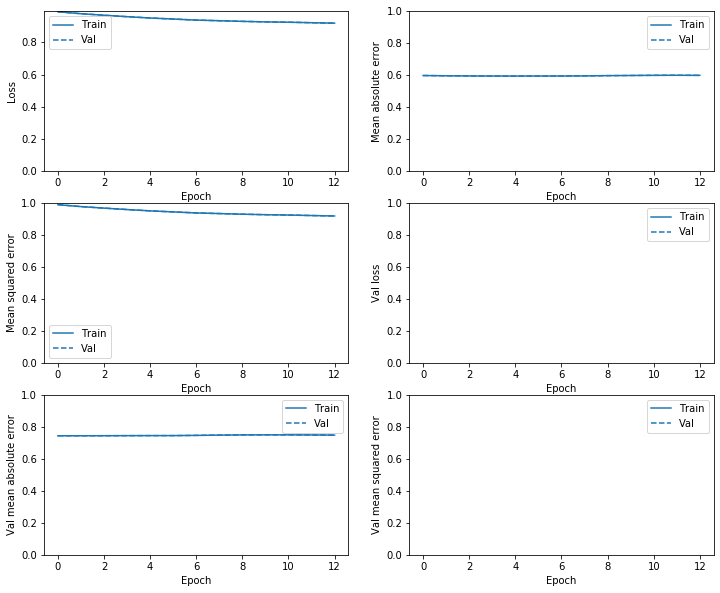

In [48]:
plot_metrics(history)

In [49]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 3.4465 - mean_absolute_error: 0.7484 - mean_squared_error: 3.4465


In [50]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

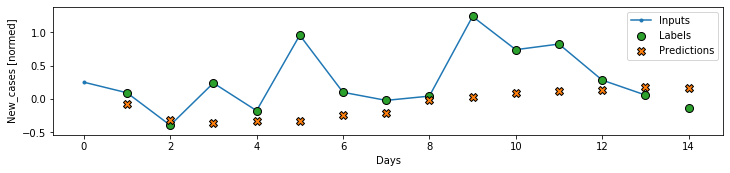

In [51]:
wide_window.plot(lstm_model)

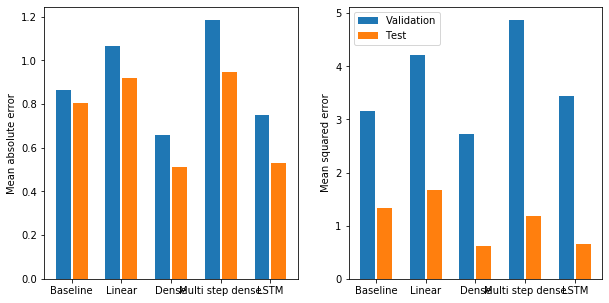

In [52]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

### Multi-output

In [53]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [54]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [55]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 1.9152 - mean_absolute_error: 0.5080 - mean_squared_error: 1.9152


In [56]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

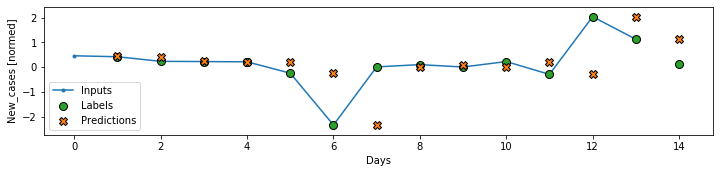

In [57]:
wide_window.plot(baseline, plot_col=compart)

In [58]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [59]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 53ms/step - loss: 1.0477 - mean_absolute_error: 0.5624 - mean_squared_error: 1.0477 - val_loss: 1.2963 - val_mean_absolute_error: 0.4164 - val_mean_squared_error: 1.2963
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 1.0078 - mean_absolute_error: 0.5359 - mean_squared_error: 1.0078 - val_loss: 1.2973 - val_mean_absolute_error: 0.4112 - val_mean_squared_error: 1.2973
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 0.9903 - mean_absolute_error: 0.5255 - mean_squared_error: 0.9903 - val_loss: 1.3263 - val_mean_absolute_error: 0.4125 - val_mean_squared_error: 1.3263


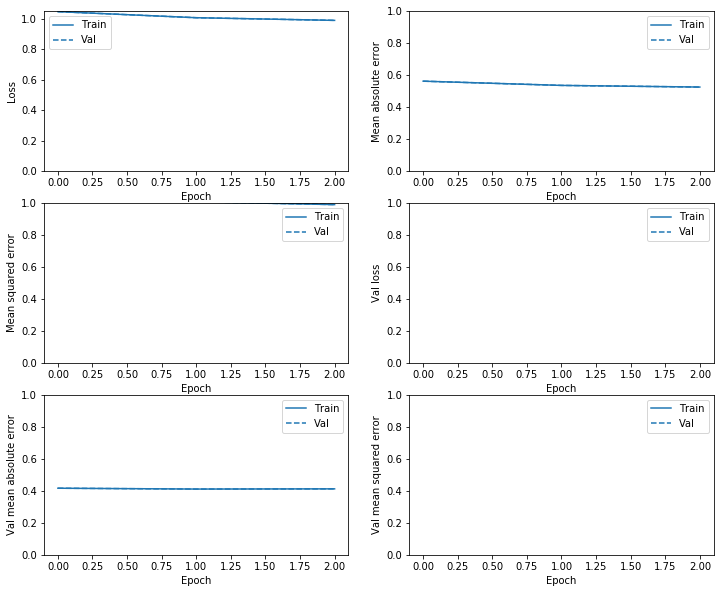

In [60]:
plot_metrics(history)

In [61]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 1.3263 - mean_absolute_error: 0.4125 - mean_squared_error: 1.3263


In [62]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

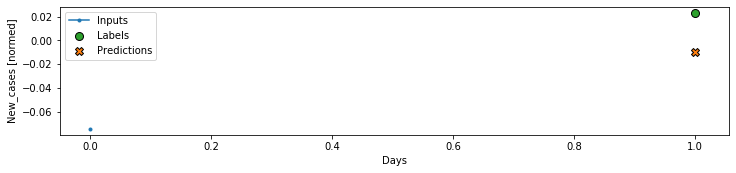

In [63]:
single_step_window.plot(dense, plot_col=compart)

In [64]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
3/3 [==============================] - 1s 189ms/step - loss: 1.0457 - mean_absolute_error: 0.5649 - mean_squared_error: 1.0457 - val_loss: 1.7384 - val_mean_absolute_error: 0.4338 - val_mean_squared_error: 1.7384
Epoch 2/50
3/3 [==============================] - 0s 22ms/step - loss: 1.0406 - mean_absolute_error: 0.5640 - mean_squared_error: 1.0406 - val_loss: 1.7367 - val_mean_absolute_error: 0.4334 - val_mean_squared_error: 1.7367
Epoch 3/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0361 - mean_absolute_error: 0.5635 - mean_squared_error: 1.0361 - val_loss: 1.7370 - val_mean_absolute_error: 0.4327 - val_mean_squared_error: 1.7370
Epoch 4/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0315 - mean_absolute_error: 0.5632 - mean_squared_error: 1.0315 - val_loss: 1.7352 - val_mean_absolute_error: 0.4316 - val_mean_squared_error: 1.7352
Epoch 5/50
3/3 [==============================] - 0s 27ms/step - loss: 1.0279 - mean_absolute_error: 0.5631

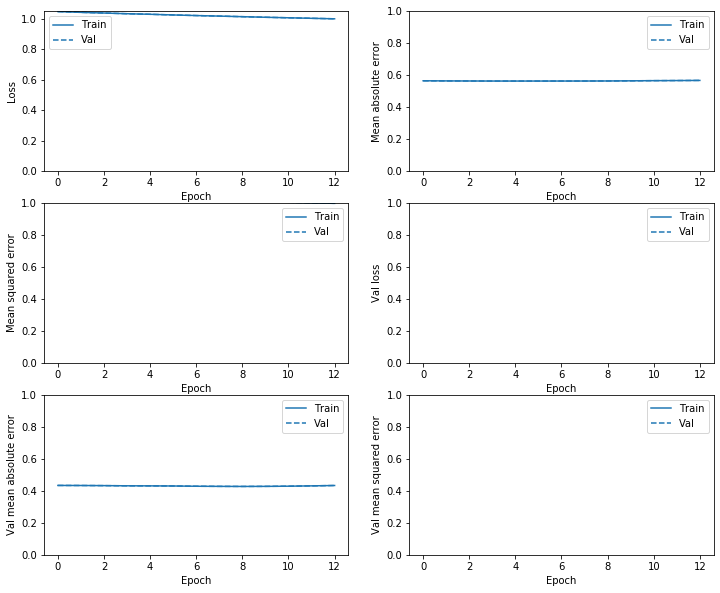

In [65]:
plot_metrics(history)

In [66]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 1.7301 - mean_absolute_error: 0.4335 - mean_squared_error: 1.7301


In [67]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

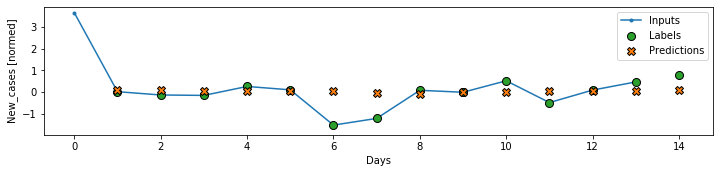

In [68]:
wide_window.plot(lstm_model, plot_col=compart)

In [69]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/50
3/3 [==============================] - 1s 221ms/step - loss: 2.0969 - mean_absolute_error: 0.8944 - mean_squared_error: 2.0969 - val_loss: 1.9108 - val_mean_absolute_error: 0.5084 - val_mean_squared_error: 1.9108
Epoch 2/50
3/3 [==============================] - 0s 30ms/step - loss: 2.0913 - mean_absolute_error: 0.8931 - mean_squared_error: 2.0913 - val_loss: 1.9063 - val_mean_absolute_error: 0.5089 - val_mean_squared_error: 1.9063
Epoch 3/50
3/3 [==============================] - 0s 40ms/step - loss: 2.0855 - mean_absolute_error: 0.8917 - mean_squared_error: 2.0855 - val_loss: 1.9018 - val_mean_absolute_error: 0.5096 - val_mean_squared_error: 1.9018
Epoch 4/50
3/3 [==============================] - 0s 35ms/step - loss: 2.0792 - mean_absolute_error: 0.8903 - mean_squared_error: 2.0792 - val_loss: 1.8972 - val_mean_absolute_error: 0.5104 - val_mean_squared_error: 1.8972
Epoch 5/50
3/3 [==============================] - 0s 34ms/step - loss: 2.0723 - mean_absolute_error: 0.8889

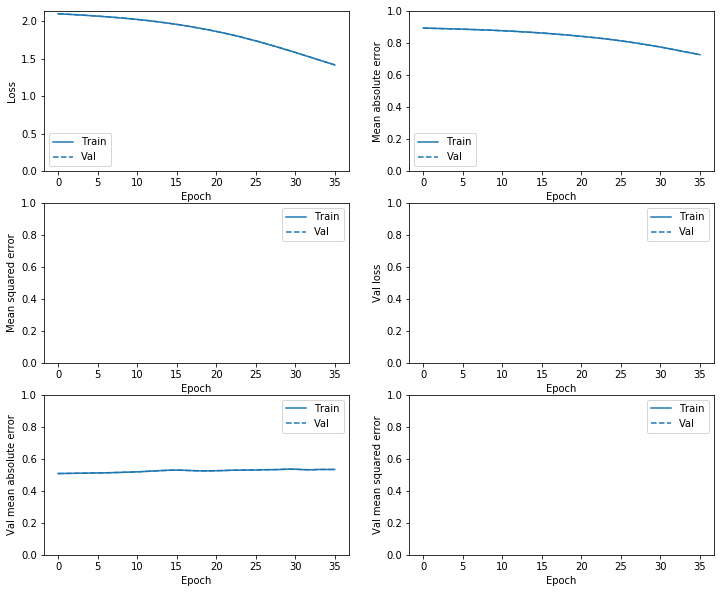

In [70]:
plot_metrics(history)

In [71]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 1.7038 - mean_absolute_error: 0.5338 - mean_squared_error: 1.7038


In [72]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

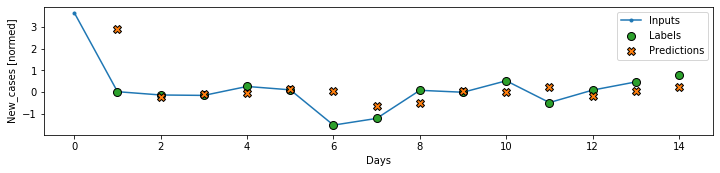

In [73]:
wide_window.plot(residual_lstm, plot_col=compart)

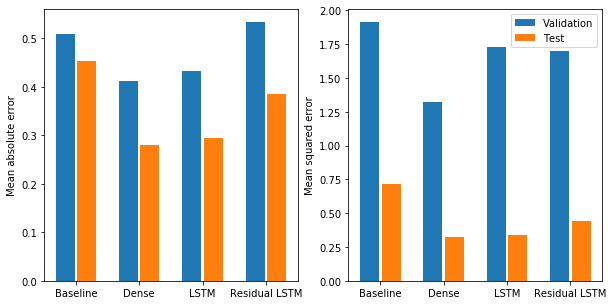

In [74]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

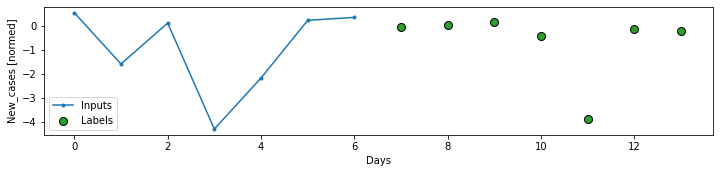

In [75]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot()

In [76]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [77]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

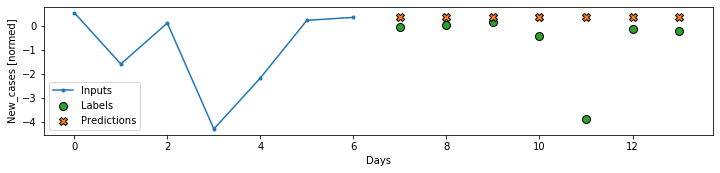

In [78]:
multi_window.plot(last_baseline)

In [79]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [80]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

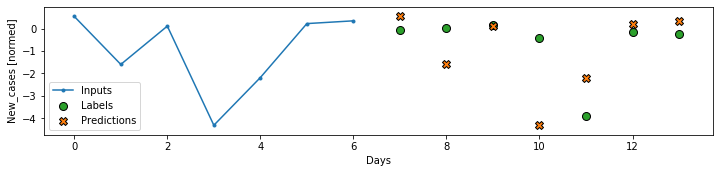

In [81]:
multi_window.plot(repeat_baseline)

### Single shot

In [82]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 67ms/step - loss: 1.0919 - mean_absolute_error: 0.5739 - mean_squared_error: 1.0919 - val_loss: 2.0823 - val_mean_absolute_error: 0.4691 - val_mean_squared_error: 2.0823
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0909 - mean_absolute_error: 0.5738 - mean_squared_error: 1.0909 - val_loss: 2.0821 - val_mean_absolute_error: 0.4692 - val_mean_squared_error: 2.0821
Epoch 3/50
3/3 [==============================] - 0s 29ms/step - loss: 1.0899 - mean_absolute_error: 0.5737 - mean_squared_error: 1.0899 - val_loss: 2.0816 - val_mean_absolute_error: 0.4692 - val_mean_squared_error: 2.0816
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 1.0892 - mean_absolute_error: 0.5736 - mean_squared_error: 1.0892 - val_loss: 2.0814 - val_mean_absolute_error: 0.4692 - val_mean_squared_error: 2.0814
Epoch 5/50
3/3 [==============================] - 0s 26ms/step - loss: 1.0885 - mean_absolute_error: 0.5736 

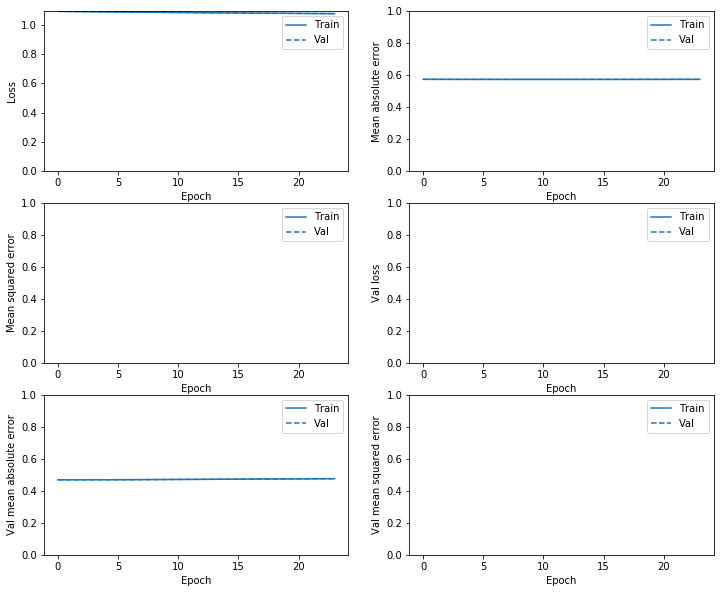

In [83]:
plot_metrics(history)

In [84]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 2.0800 - mean_absolute_error: 0.4761 - mean_squared_error: 2.0800


In [85]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

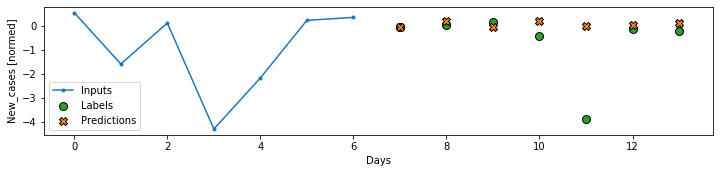

In [86]:
multi_window.plot(multi_linear_model)

In [87]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 66ms/step - loss: 1.0922 - mean_absolute_error: 0.5750 - mean_squared_error: 1.0922 - val_loss: 2.0853 - val_mean_absolute_error: 0.4734 - val_mean_squared_error: 2.0853
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 1.0800 - mean_absolute_error: 0.5738 - mean_squared_error: 1.0800 - val_loss: 2.0835 - val_mean_absolute_error: 0.4758 - val_mean_squared_error: 2.0835
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 1.0702 - mean_absolute_error: 0.5741 - mean_squared_error: 1.0702 - val_loss: 2.0849 - val_mean_absolute_error: 0.4812 - val_mean_squared_error: 2.0849
Epoch 4/50
3/3 [==============================] - 0s 31ms/step - loss: 1.0633 - mean_absolute_error: 0.5750 - mean_squared_error: 1.0633 - val_loss: 2.0880 - val_mean_absolute_error: 0.4881 - val_mean_squared_error: 2.0880


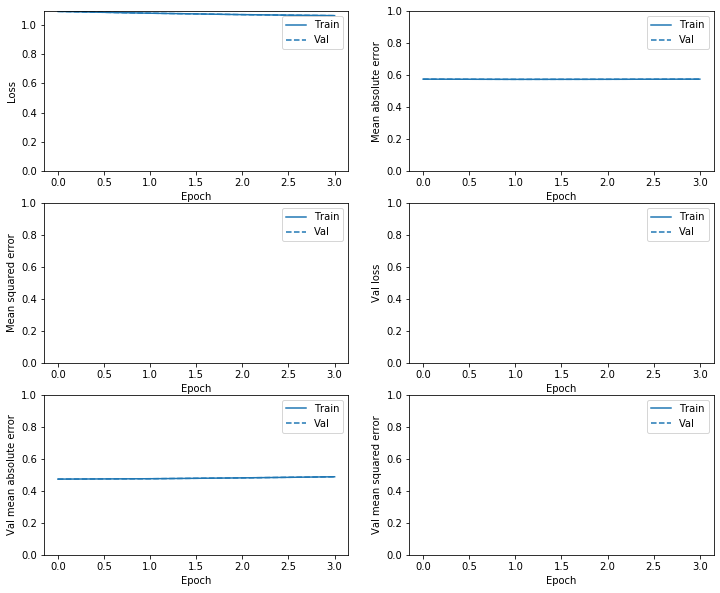

In [88]:
plot_metrics(history)

In [89]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 2.0880 - mean_absolute_error: 0.4881 - mean_squared_error: 2.0880


In [90]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

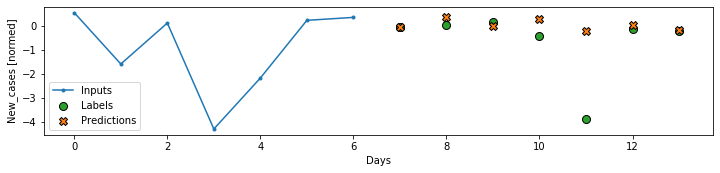

In [91]:
multi_window.plot(multi_dense_model)

In [92]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/50
3/3 [==============================] - 1s 212ms/step - loss: 1.0918 - mean_absolute_error: 0.5738 - mean_squared_error: 1.0918 - val_loss: 2.0827 - val_mean_absolute_error: 0.4690 - val_mean_squared_error: 2.0827
Epoch 2/50
3/3 [==============================] - 0s 33ms/step - loss: 1.0904 - mean_absolute_error: 0.5736 - mean_squared_error: 1.0904 - val_loss: 2.0826 - val_mean_absolute_error: 0.4689 - val_mean_squared_error: 2.0826
Epoch 3/50
3/3 [==============================] - 0s 36ms/step - loss: 1.0893 - mean_absolute_error: 0.5735 - mean_squared_error: 1.0893 - val_loss: 2.0826 - val_mean_absolute_error: 0.4691 - val_mean_squared_error: 2.0826
Epoch 4/50
3/3 [==============================] - 0s 40ms/step - loss: 1.0881 - mean_absolute_error: 0.5734 - mean_squared_error: 1.0881 - val_loss: 2.0825 - val_mean_absolute_error: 0.4692 - val_mean_squared_error: 2.0825
Epoch 5/50
3/3 [==============================] - 0s 40ms/step - loss: 1.0865 - mean_absolute_error: 0.5733

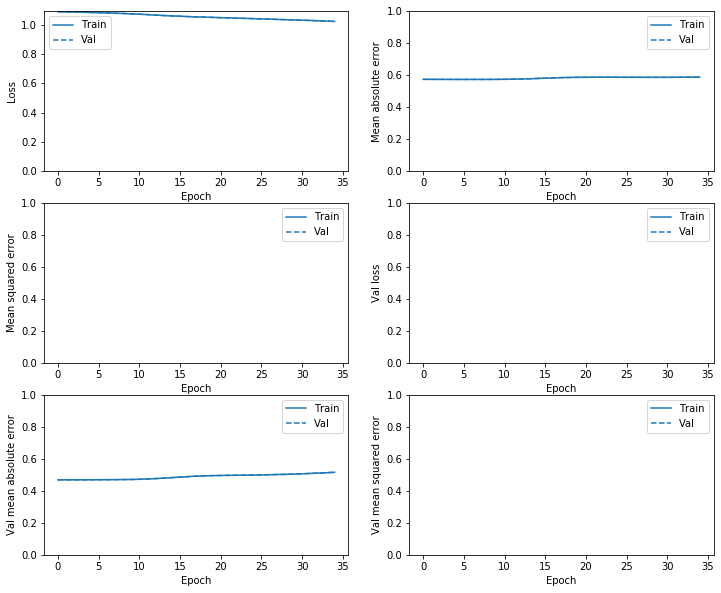

In [93]:
plot_metrics(history)

In [94]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 4ms/step - loss: 2.0618 - mean_absolute_error: 0.5159 - mean_squared_error: 2.0618


In [95]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

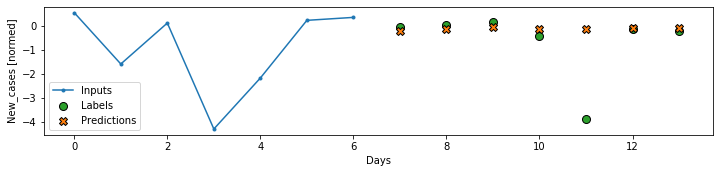

In [96]:
multi_window.plot(multi_lstm_model)

## AR model

In [97]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [98]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [99]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/50
3/3 [==============================] - 0s 162ms/step - loss: 1.0940 - mean_absolute_error: 0.5776 - mean_squared_error: 1.0940 - val_loss: 2.1089 - val_mean_absolute_error: 0.4820 - val_mean_squared_error: 2.1089
Epoch 2/50
3/3 [==============================] - 0s 25ms/step - loss: 1.0883 - mean_absolute_error: 0.5762 - mean_squared_error: 1.0883 - val_loss: 2.1071 - val_mean_absolute_error: 0.4800 - val_mean_squared_error: 2.1071
Epoch 3/50
3/3 [==============================] - 0s 30ms/step - loss: 1.0831 - mean_absolute_error: 0.5754 - mean_squared_error: 1.0831 - val_loss: 2.1066 - val_mean_absolute_error: 0.4768 - val_mean_squared_error: 2.1066
Epoch 4/50
3/3 [==============================] - 0s 33ms/step - loss: 1.0787 - mean_absolute_error: 0.5754 - mean_squared_error: 1.0787 - val_loss: 2.1057 - val_mean_absolute_error: 0.4760 - val_mean_squared_error: 2.1057
Epoch 5/50
3/3 [==============================] - 0s 38ms/step - loss: 1.0737 - mean_absolute_error: 0.5752

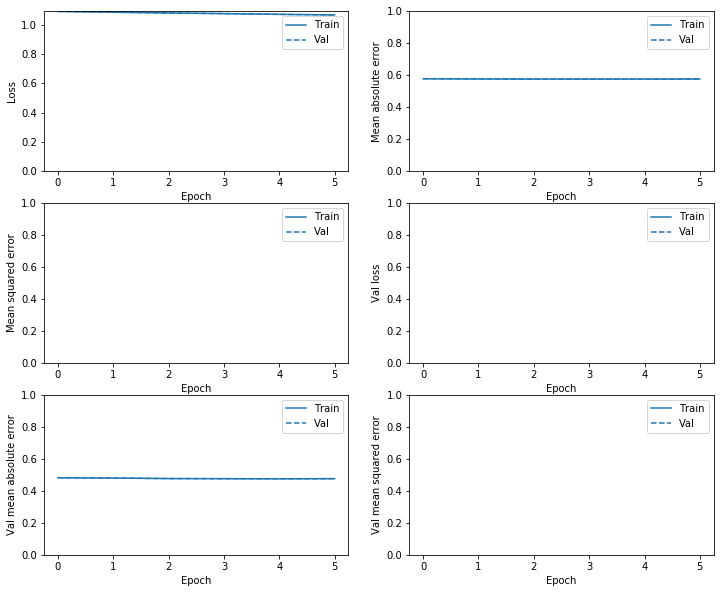

In [100]:
plot_metrics(history)

In [101]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 2.1057 - mean_absolute_error: 0.4762 - mean_squared_error: 2.1057


In [102]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

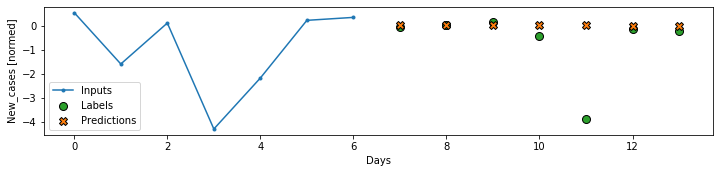

In [103]:
multi_window.plot(feedback_model)

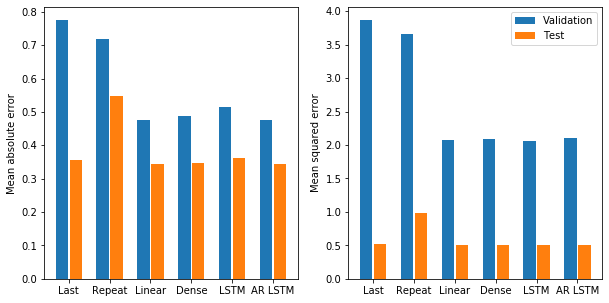

In [104]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance)